<a href="https://colab.research.google.com/github/Eldave93/Seizure-Detection-Tutorials/blob/master/Classification_03_Model_Evaluation_and_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Tutorial #03

# Model Evaluation and Hyperparameter Tuning

by [David Luke Elliott](https://www.lancaster.ac.uk/psychology/about-us/people/david-elliott)
/ [GitHub](https://github.com/Eldave93) 

In the previous notebook we had an overview of some of the supervised classifiers available in scikit-learn. 

In this notebook we are going to look at methods for evaluating the performance of these classifiers and how to tune the hyperparameters of the models to fit our data better. This will enable us to get a better sense of how the models will generalize to unseen data better, as well as get better performance out of our models.

# Load Data

First lets start by getting our workspace ready and then loading in the data.

**Notes**
- See the Feature Extraction Tutorial (Epileptologie) or Feature Pre-Processing tutorials if your unsure how to get the data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


You may need to change below to where you have saved the dataset

In [0]:
FILE_PATH = '/content/gdrive/My Drive/Data/feature_df.json.gzip'

In [3]:
import os                         # for file locations
import matplotlib.pyplot as plt   # for plotting
import numpy as np                # arrays
import pickle                     # saving python objects
import pandas as pd               # dataframes

# colours for printing outputs
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# load features dataframe
feature_df = pd.read_json(FILE_PATH, orient='index', compression = 'gzip')

# display examples of the data
display(feature_df.info())
display(feature_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 38 columns):
D1_LSWT        500 non-null float64
D1_Ratio       500 non-null float64
D1_mean        500 non-null float64
D1_mean_abs    500 non-null float64
D1_std         500 non-null float64
D2_LSWT        500 non-null float64
D2_Ratio       500 non-null float64
D2_mean        500 non-null float64
D2_mean_abs    500 non-null float64
D2_std         500 non-null float64
D3_LSWT        500 non-null float64
D3_Ratio       500 non-null float64
D3_mean        500 non-null float64
D3_mean_abs    500 non-null float64
D3_std         500 non-null float64
D4_LSWT        500 non-null float64
D4_Ratio       500 non-null float64
D4_mean        500 non-null float64
D4_mean_abs    500 non-null float64
D4_std         500 non-null float64
D5_LSWT        500 non-null float64
D5_Ratio       500 non-null float64
D5_mean        500 non-null float64
D5_mean_abs    500 non-null float64
D5_std         500 non-null flo

None

,D1_LSWT,D1_Ratio,D1_mean,D1_mean_abs,D1_std,D2_LSWT,D2_Ratio,D2_mean,D2_mean_abs,D2_std,...,D6_mean_abs,D6_std,class,file_id,location,power_alpha,power_beta,power_delta,power_gamma,power_theta
0,3.665018,0.362810,-0.041443,1.910710,2.479649,4.749819,0.631333,-0.008293,5.266416,6.528848,...,76.722313,95.640549,baseline,F001,intracranial epileptogenic zone,13.102026,4.033713,125.389091,1.101212,38.175072
1,8.020356,0.208105,-0.002805,1.761159,3.013578,8.062119,0.514802,0.120496,8.462824,18.706007,...,281.597393,402.092208,baseline,F002,intracranial epileptogenic zone,201.886582,52.737781,3797.194021,14.147616,492.166476
2,7.170449,0.210005,-0.034373,2.179047,4.973884,7.197397,0.499067,-0.034026,10.376156,15.889841,...,298.635855,360.445632,baseline,F003,intracranial epileptogenic zone,135.970946,39.098686,787.823018,8.769312,208.119170
3,6.950912,0.365782,-0.032627,1.812019,2.324897,7.086014,0.516294,0.081712,4.953816,6.422304,...,127.731141,167.126107,baseline,F004,intracranial epileptogenic zone,34.191639,7.443866,240.974656,1.923739,105.055098
4,8.480473,0.198041,0.081691,3.478807,6.027705,8.460379,0.625299,0.069729,17.566081,28.556063,...,270.422836,349.299940,baseline,F005,intracranial epileptogenic zone,218.880920,68.804894,1154.608671,18.070537,462.277208


# Data Preparation

The below broadly copies some of the data preparation from the previous notebooks

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2
RANDOM_STATE = 0

feature_reduced = feature_df[feature_df.location != 'surface']
feature_reduced_drop = feature_reduced.drop(['class', 'file_id', 'location'], 
                                            axis='columns')
data_x = feature_reduced_drop.values

# make a label encoder
le = LabelEncoder()
# change the string labels to ints
data_y = le.fit_transform(feature_reduced['class'])
    
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=TEST_SIZE, 
                                                  random_state=RANDOM_STATE)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(192, 35) (48, 35) (60, 35)
(192,) (48,) (60,)


# Classifiers

We came across a number of classifiers last time. Lets quickly make a few so we can compare and change them later.

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Logistic Regression
pipe_reg = Pipeline([('scl', StandardScaler()),
                     ('clf', LogisticRegression(class_weight='balanced',
                                                solver = 'liblinear',
                                                random_state=RANDOM_STATE))])

# Support Vector Machine
pipe_svc = Pipeline([('scl', StandardScaler()),
                    ('clf', SVC(kernel='rbf', 
                                class_weight = 'balanced',
                                probability=True,
                                random_state=RANDOM_STATE))])

# Decision Tree
DT = DecisionTreeClassifier(random_state=RANDOM_STATE)

# K-Nearest Neighbours
pipe_kkn = Pipeline([('scl', StandardScaler()),
                    ('clf', KNeighborsClassifier())])

# list of classifier names
classifier_names = ['Logistic Regression', 'Support Vector Machine', 
                    'Decision Tree', 'K-Nearest Neighbors']

# list of classifiers
classifiers = [pipe_reg, pipe_svc, DT, pipe_kkn]

# fit all the classifiers to the training data
for classifier in classifiers:
  classifier.fit(X_train, y_train)

# Performance Evaluation

We have been focusing on accuracy to evaluate a models performance, but we can get much more information about our models performance. 

## Metrics

Lets first have a look at a 'confusion matrix' when the logistic regression model is fit to the validation data. A confusion matrix shows what the models predicted label was and what the actual label is.

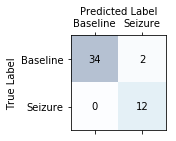

In [6]:
from sklearn.metrics import confusion_matrix

def pretty_confusion_matrix(confmat):

    # this creates the matplotlib graph to make the confmat look nicer
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
       
    # change the labels
    ax.set_xticklabels(['']+['Baseline', 'Seizure'])
    ax.set_yticklabels(['']+['Baseline', 'Seizure'])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax.xaxis.set_label_position('top')

    plt.tight_layout()
    
    plt.show()
    
    
# use the first classifier to predict the validation set    
predictions = classifiers[0].predict(X_val)

# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true=y_val, y_pred=predictions)

# use the pretty function to make it nicer
pretty_confusion_matrix(confmat)

Using this confusion matrix we can manually work out a number of different performance metrics.

> **Error and Accuracy** 

> Give general performance information regarding the number of all correct or false predictions comparative to the total number of predictions for both the positive and negative labels.

> **Recall (or True Positive Rate)** 

> Calculates how many of the actual positives our model correctly or incorrectly labelled. This is useful when the fraction of correctly or misclassified samples in the positive class are of interest.

> **Precision (PRE)** 

> Precision gives information on how precise your model is by looking at how many positive predicted labels are actually positive. To calculate it you just take the true  positives and divide it by the total true and false positives. Precision is a good measure to determine, when the costs of a False Positive is high.

> **F1-score**

> F1-score is a combination of Recall and Precision used when there is an uneven class distribution due to a large number of Actual Negatives that you are not as focused on. 

Different metrics maybe more appropriate depending on the application. For example, the priority may be to identify seizures and not as much on correctly identifying inter-ictal periods, therefore recall would be a better metic to look at. If we are looking at patients at risk for Sudden Unexpected Death in Epilepsy (SUDEP), then the costs of having a miss-classified actual positive (or false negative) is very high.

**Note**
- In the descriptions ictal activity would be the positive prediction and interical activity the negative.

---

1. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.
2. https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

In [7]:
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

ERR = (FP+FN)/(FP+FN+TP+TN)
ACC = 1-ERR
TPR = TP/(FN+TP)
FPR = FP/(FP+TN)
PRE = TP/(TP+FP)
REC = TP/(FN+TP)
F1 = 2*((PRE*REC)/(PRE+REC))

print('True positive rate (TPR): %.3f' % TPR)
print('False positive rate (FPR): %.3f' % FPR)
print('Error (ERR): %.3f' % ERR)
print()
print('Accuracy (ACC): %.3f' % ACC)
print('Precision (PRE): %.3f' % PRE)
print('Recall (REC): %.3f' % REC)
print('F1-score (F1): %.3f' % F1)

True positive rate (TPR): 1.000
False positive rate (FPR): 0.056
Error (ERR): 0.042

Accuracy (ACC): 0.958
Precision (PRE): 0.857
Recall (REC): 1.000
F1-score (F1): 0.923


Rather than manually calculating the metrics, we can use the inbuilt sklearn method to calculate them.

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score

print('Accuracy (ACC): %.3f' % accuracy_score(y_true=y_val, y_pred=predictions))
print('Precision (PRE): %.3f' % precision_score(y_true=y_val, y_pred=predictions))
print('Recall (REC): %.3f' % recall_score(y_true=y_val, y_pred=predictions))
print('F1-score (F1): %.3f' % f1_score(y_true=y_val, y_pred=predictions))

Accuracy (ACC): 0.958
Precision (PRE): 0.857
Recall (REC): 1.000
F1-score (F1): 0.923


Furthermore we can use a classification report, which gives more information such as the micro avg, macro avg, and weighted avg; although we can still specify this in the previous method using the average parameter.


> **Macro Average**
- Treats all classes equally as each metric is calculated independently and the average is taken.

> **Micro Average**
- Aggregates the contributions of all classes and computes an average metric. 
- This is preferable to macro avg  in cases with class imbalances.

> **Weighted Average** 
- Each contribution to the average is weighted by the relative number of examples in a class available.

**NOTES**
- The support is the number of occurrences of each class in y_true.
- Notice how the previous metrics were based on the seizure scores. This is because in binary classification problems, the default positive label is the target (class 1). You can change this if you are more interested in the other classes performance or the average metrics.

---
https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin

In [9]:
from sklearn.metrics import classification_report

pd.DataFrame(classification_report(y_val, 
                                   predictions, 
                                   labels=None, 
                                   target_names=['Baseline', 'Seizure'], 
                                   sample_weight=None, 
                                   digits=2, 
                                   output_dict=True))

,Baseline,Seizure,micro avg,macro avg,weighted avg
f1-score,0.971429,0.923077,0.958333,0.947253,0.959341
precision,1.000000,0.857143,0.958333,0.928571,0.964286
recall,0.944444,1.000000,0.958333,0.972222,0.958333
support,36.000000,12.000000,48.000000,48.000000,48.000000


If we have a look at the confusion matrix for the othe methods we can see different methods are either producing similar or different errors

Support Vector Machine


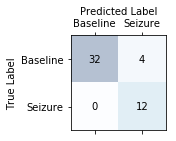

Decision Tree


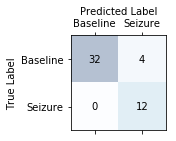

K-Nearest Neighbors


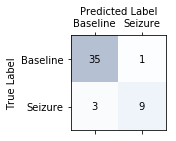

In [10]:
for i, classifier in enumerate(classifiers[1:]):
  print(color.BOLD+color.UNDERLINE+classifier_names[i+1]+color.END)

  predictions = classifier.predict(X_val)

  confmat = confusion_matrix(y_true=y_val, y_pred=predictions)

  pretty_confusion_matrix(confmat)

Lets confirm this by combining all the metrics into one dataframe to compare

In [11]:
for i, classifier in enumerate(classifiers):
  predictions = classifier.predict(X_val)

  classifier_score_df = pd.DataFrame(
      classification_report(y_val, 
                            predictions,
                            target_names=['Baseline', 'Seizure'],
                            digits=2, 
                            output_dict=True))
  
  classifier_score_df.index.name = 'Metric'
  classifier_score_df['Classifier'] = classifier_names[i]
  classifier_score_df = classifier_score_df.set_index('Classifier', append=True)
  
  if i == 0:
    all_scores = classifier_score_df

  else:
    all_scores = pd.concat([all_scores, classifier_score_df])
        
all_scores.sort_index()

Baseline    Seizure  micro avg  macro avg  \
Metric    Classifier                                                           
f1-score  Decision Tree            0.941176   0.857143   0.916667   0.899160   
          K-Nearest Neighbors      0.945946   0.818182   0.916667   0.882064   
          Logistic Regression      0.971429   0.923077   0.958333   0.947253   
          Support Vector Machine   0.941176   0.857143   0.916667   0.899160   
precision Decision Tree            1.000000   0.750000   0.916667   0.875000   
          K-Nearest Neighbors      0.921053   0.900000   0.916667   0.910526   
          Logistic Regression      1.000000   0.857143   0.958333   0.928571   
          Support Vector Machine   1.000000   0.750000   0.916667   0.875000   
recall    Decision Tree            0.888889   1.000000   0.916667   0.944444   
          K-Nearest Neighbors      0.972222   0.750000   0.916667   0.861111   
          Logistic Regression      0.944444   1.000000   0.958333   0.972222   
          Support Vector Machine   0.888889   1.000000   0.916667   0.944444   
support   Decision Tree           36.000000  12.000000  48.000000  48.000000   
          K-Nearest Neighbors     36.000000  12.000000  48.000000  48.000000   
          Logistic Regression     36.000000  12.000000  48.000000  48.000000   
          Support Vector Machine  36.000000  12.000000  48.000000  48.000000   

                                  weighted avg  
Metric    Classifier                            
f1-score  Decision Tree               0.920168  
          K-Nearest Neighbors         0.914005  
          Logistic Regression         0.959341  
          Support Vector Machine      0.920168  
precision Decision Tree               0.937500  
          K-Nearest Neighbors         0.915789  
          Logistic Regression         0.964286  
          Support Vector Machine      0.937500  
recall    Decision Tree               0.916667  
          K-Nearest Neighbors         0.916667  
          Logistic Regression         0.958333  
          Support Vector Machine      0.916667  
support   Decision Tree              48.000000  
          K-Nearest Neighbors        48.000000  
          Logistic Regression        48.000000  
          Support Vector Machine     48.000000

## Receiver Operating Characteristic (ROC) Curve

We can also use plots to visualise each models performance. 

ROC curves are useful for comparing classification models based on their false positive and true positive rate performance. A ROC curve is computed by shifting the decision threshold of the classifier<sup>1</sup>.

**NOTES**
- For the SVM, probability needs to be true

---

1. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.

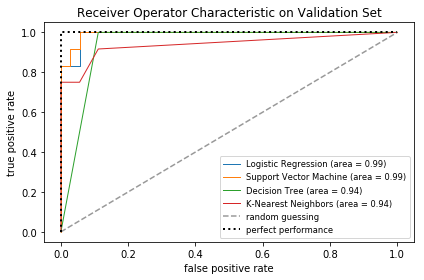

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.externals import joblib
import re

def ROC(classifiers, classifier_names, X_train, 
        X_val, y_train, y_val, image_file_path):
  
  # for each classifier...
  for i, classifer in enumerate(classifiers):
    # fit the pipeline
    probas = classifer.fit(X_train,
                                y_train).predict_proba(X_val)

    # get the roc curve info
    fpr, tpr, thresholds = roc_curve(y_val, 
                                     probas[:, 1], 
                                     pos_label=1)

    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, 
             tpr, 
             lw=1, 
             label='{} (area = %0.2f)'.format(classifier_names[i]) %roc_auc)

  plt.plot([0, 1], 
           [0, 1], 
           linestyle='--', 
           color=(0.6, 0.6, 0.6), 
           label='random guessing')

  plt.plot([0, 0, 1], 
           [0, 1, 1], 
           lw=2, 
           linestyle=':', 
           color='black', 
           label='perfect performance')

  plt.xlim([-0.05, 1.05])
  plt.ylim([-0.05, 1.05])
  plt.xlabel('false positive rate')
  plt.ylabel('true positive rate')
  plt.title('Receiver Operator Characteristic on Validation Set')
  plt.legend(loc="lower right", fontsize ='small')

  plt.tight_layout()
  plt.savefig(image_file_path, dpi=300)
  plt.show()    
    

ROC(classifiers, classifier_names, X_train, X_val, y_train, 
    y_val, 'Classifiers_ROC.png')

## Precision-recall Curve

To explain precision-recall curves the Scikit-learn documentation is pretty useful (as seen below):

> *"The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).*

> *A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly."*<sup>1</sup>

PR curves are useful in unballanced datasets, such as when the positive class is rare, or when false positives are more important than false negatives; otherwise a ROC curve is generally more useful<sup>2<sup>.

**Note**
- Precision Curves only work with classifiers that have a decision_function such as SVM
  
---
1. https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
2. Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".

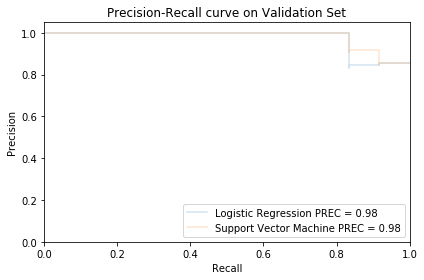

In [13]:
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.externals import joblib
from sklearn.metrics import average_precision_score

def Precision_Curve(classifier_list, classifier_names, X_train, 
                    X_val, y_train, y_val, image_file_path):

  # for each classifier...
  for i, classifer_ in enumerate(classifier_list):

      y_score = classifer_.decision_function(X_val)

      precision, recall, _ = precision_recall_curve(y_val, y_score)

      average_precision = average_precision_score(y_val, y_score)

      plt.step(recall, precision, alpha=0.2, where='post', 
               label=classifier_names[i]+' PREC = %0.2f'% average_precision)

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title('Precision-Recall curve on Validation Set')
  plt.legend(loc="lower right")

  plt.tight_layout()
  plt.savefig(image_file_path, dpi=300)
  plt.show()

Precision_Curve(classifiers[:2], classifier_names[:2], X_train, X_val, 
                y_train, y_val, 'Classifiers_PREC.png')

## Learning Curve

Learning curves can be used to see if an algorithm has a problem with overfitting (high variance) or underfitting (high bias) to the training data. It could be that the model is too complex for the training dataset leading it to not generalize well to unseen data. We can plot the degree to which a model is over/under-fitting to the training data as we add in more training data. What we are looking for is that as the number of training samples increases the chosen scoring metrics for the training and test sets get closer together.

What these curves are telling us about our model is that are likely overfitting to the training data. To address this we could<sup>1</sup>:
- collect more training data
- reduce the complexity of the model
- increase the regularization parameter
- decrease the number of features via feature selection or feature extraction (Classification 05 Tutorial)

**NOTES**
- for the plotting I'm using a package called mlxtend<sup>2</sup>

---

1. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.

2. Raschka, Sebastian. Mlxtend(Version 0.13.0). doi = 10.5281/zenodo.594432, url = http://dx.doi.org/10.5281/zenodo.594432

Support Vector Machine


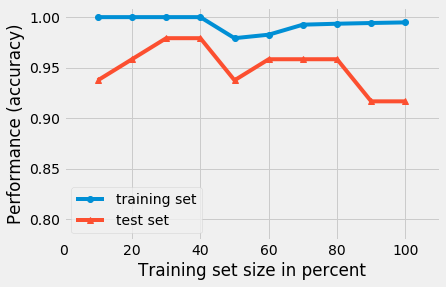

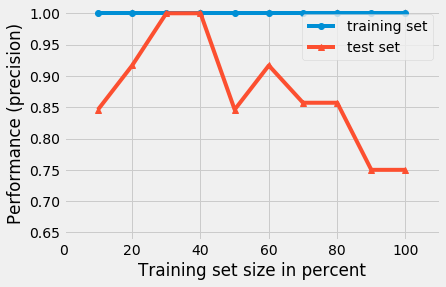

In [14]:
from mlxtend.plotting import plot_learning_curves

learning_curve_scoring = ['accuracy', 'precision']


print(color.BOLD+color.UNDERLINE+classifier_names[1]+color.END)
for scoring_method in learning_curve_scoring:
  plot_learning_curves(X_train, y_train, X_val, y_val, classifiers[1], 
                       train_marker='o', test_marker='^', 
                       scoring=scoring_method, print_model =False)
  if scoring_method in ['accuracy', 'precision']:
      plt.ylim(top=1.01)
  plt.show()

## Cross-Validation

So far we have only assessed our models performance on splitting our data into training, validation, and test sets (the holdout method). The validation set is used during training and setting hyperparameters, and the test set can be used once a final model is selected for final performance evaluation<sup>1</sup>. This is a popular approach to generalization performance, however as we will see, we can't keep using the same validation set when trying different hyperparameters as the model will be more likely to over-fit to the current data and be less generalisable when deployed in the real world.

So first lets split our data back into training and test sets.

---

1. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data_x, 
                                                    data_y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

### K-Fold Cross-Validation

There is a disadvantage to the holdout method, as where the splits of the training, validation, and test sets are will effect performance. Therefore a more robust technique is to split the training data into multipule training and validation sets (e.g. K-Fold Cross-Validation). We randomly split the training set into *k* folds without replacement so *k*-1 folds are used for model training with one fold used for performance evaluation. As this is repeated *k* times we get *k* models and performance estimates, of which the average performance is taken. As the k-fold cross-validation resamples without replacement, each sample point will have been used in both the training and validation sets once<sup>1</sup>.

A good default value for K is 10, however if the training sets are small it may be better to increase the number of folds, and if the data is large reduce it<sup>2</sup>.

First I will show how it splits up data. This code could be used for analysis but is not as efficient as the subsequent block. As such I'll keep the number of splits and repeats low to demonstrate.

---

1. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.

2. R. Kohavi et al. A Study of Cross-validation and Bootstrap for Accuracy Estimation and Model Selection. In Ijcai, volume 14, pages 1137–1145, 1995

In [16]:
%%time
import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.base import clone

N_SPLITS = 2
N_REPEATS = 2

RepKFold = RepeatedKFold(n_splits = N_SPLITS,
                         n_repeats = N_REPEATS,
                         random_state=RANDOM_STATE)

scores = []
i = 0
for train_index, validation_index in RepKFold.split(X_train, y_train):
  clone_clf = clone(pipe_reg)

  clone_clf.fit(X_train[train_index], y_train[train_index])
  score = clone_clf.score(X_train[validation_index], y_train[validation_index])
  scores.append(score)

  print(color.BOLD+color.UNDERLINE+'Fold '+str(i+1)+color.END)
  print('Class dist.: %s, Acc: %.3f' % (np.bincount(y_train[train_index]), score))
  print("\nTRAIN:", train_index)
  print("\nVALIDATION:", validation_index)
  print()
  i+=1
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold 1
Class dist.: [80 40], Acc: 0.933

TRAIN: [  0   1   2   6   9  10  11  17  21  23  25  28  29  31  32  34  35  36
  38  39  42  43  47  48  49  53  57  58  59  65  67  68  69  70  72  77
  78  79  81  82  84  85  87  88  91  93  94  95  98  99 100 102 103 105
 112 113 114 115 117 119 120 121 127 128 131 132 133 137 140 141 142 143
 146 147 148 150 151 160 163 164 165 167 172 173 174 175 177 180 182 183
 185 186 187 189 190 192 193 195 196 197 198 200 203 204 205 207 208 211
 212 216 222 223 224 225 228 229 232 236 237 238]

VALIDATION: [  3   4   5   7   8  12  13  14  15  16  18  19  20  22  24  26  27  30
  33  37  40  41  44  45  46  50  51  52  54  55  56  60  61  62  63  64
  66  71  73  74  75  76  80  83  86  89  90  92  96  97 101 104 106 107
 108 109 110 111 116 118 122 123 124 125 126 129 130 134 135 136 138 139
 144 145 149 152 153 154 155 156 157 158 159 161 162 166 168 169 170 171
 176 178 179 181 184 188 191 194 199 201 202 206 209 210 213 214 215 217
 218 219 220 

However rather than manually doing it like above, we can instead use a function such as cross_val_score which allows for doing computation in parallel (n_jobs=-1).

In [17]:
%%time
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

SCORER = make_scorer(score_func=accuracy_score)

scores = cross_val_score(estimator=pipe_reg, 
                         X=X_train, 
                         y=y_train, 
                         scoring = SCORER,
                         cv=RepKFold,
                         n_jobs=-1)

print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.93333333 0.95       0.95833333 0.98333333]
CV accuracy: 0.956 +/- 0.018
CPU times: user 28.5 ms, sys: 24.3 ms, total: 52.8 ms
Wall time: 1.32 s


### Stratified K-Fold Cross-Validation

We can also use stratified k-fold cross-validation, as it can yield better bias and variance estimates in cases of unequal class proportions than RepeatedKFold<sup>1,2</sup>. This is because "stratified" refers to sampling where the classes are separated into "strata" and a probability sample is drawn from each group<sup>3</sup>.

As can be seen below we have twice as much baseline data (inter-ictal) than seizure (ictal).

---
1. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.
2. R. Kohavi et al. A Study of Cross-validation and Bootstrap for Accuracy Estimation and Model Selection. In Ijcai, volume 14, pages 1137–1145, 1995
3. https://stattrek.com/statistics/dictionary.aspx?definition=stratified_sampling

In [18]:
feature_reduced['class'].value_counts()

baseline    200
seizure     100
Name: class, dtype: int64

In [19]:
from sklearn.model_selection import StratifiedKFold
N_SPLITS = 10

StratKFold = StratifiedKFold(n_splits = N_SPLITS,
                             shuffle=False,
                             random_state=RANDOM_STATE)

scores = cross_val_score(estimator=pipe_reg, 
                         X=X_train, 
                         y=y_train, 
                         scoring = SCORER,
                         cv=StratKFold,
                         n_jobs=-1)

print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [1.         1.         0.91666667 0.95833333 1.         1.
 1.         0.91666667 1.         0.95833333]
CV accuracy: 0.975 +/- 0.033


### Cross-Validation ROC Curve

ROC curves can also be used to see the difference in performance at each fold. Lets look at k-nearest neighbour.

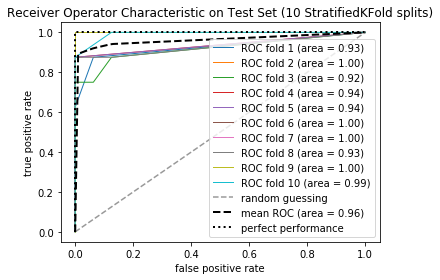

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from scipy import interp

def cross_val_ROC(classifier, cross_validator, data_x, data_y, n_splits, 
                  image_file_path):

  # default mean true positive rate
  mean_tpr = 0.0
  # default mean false positive rate
  mean_fpr = np.linspace(0, 1, 100)

  i = 0
  for train_index, validation_index in cross_validator.split(data_x, data_y):
    # fit the pipeline
    probas = classifier.fit(
        data_x[train_index],
        data_y[train_index]).predict_proba(data_x[validation_index])

    # get the roc curve info
    fpr, tpr, thresholds = roc_curve(data_y[validation_index], 
                                     probas[:, 1], 
                                     pos_label=1)

    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    i+=1
    plt.plot(fpr, 
             tpr, 
             lw=1, 
             label='ROC fold %d (area = %0.2f)' 
                    % (i, roc_auc))

  plt.plot([0, 1], 
           [0, 1], 
           linestyle='--', 
           color=(0.6, 0.6, 0.6), 
           label='random guessing')

  mean_tpr /= n_splits
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  plt.plot(mean_fpr, mean_tpr, 'k--',
           label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
  plt.plot([0, 0, 1], 
           [0, 1, 1], 
           lw=2, 
           linestyle=':', 
           color='black', 
           label='perfect performance')

  plt.xlim([-0.05, 1.05])
  plt.ylim([-0.05, 1.05])
  plt.xlabel('false positive rate')
  plt.ylabel('true positive rate')
  plt.title('Receiver Operator Characteristic on Test Set ('
            +str(n_splits)+' StratifiedKFold splits)')
  plt.legend(loc="lower right")

  plt.tight_layout()
  plt.savefig(image_file_path, dpi=300)
  plt.show()

cross_val_ROC(pipe_kkn, StratKFold, X_train, y_train, N_SPLITS, 'KNN_ROC.png')

### Cross-Validation Precision Curve

We can also use the precision curves on each fold as well.

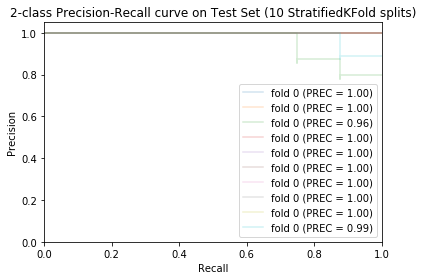

In [21]:
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.externals import joblib
from sklearn.metrics import average_precision_score

def cross_val_precision_curve(classifier, cross_validator, data_x, data_y, 
                              n_splits, image_file_path):
  # default mean true positive rate
  mean_tpr = 0.0
  # default mean false positive rate
  mean_fpr = np.linspace(0, 1, 100)

  i = 0
  for train_index, validation_index in cross_validator.split(data_x, data_y):

    # fit the pipeline
    classifier.fit(data_x[train_index],data_y[train_index])

    y_score = classifier.decision_function(data_x[validation_index])

    precision, recall, _ = precision_recall_curve(data_y[validation_index], y_score)

    average_precision = average_precision_score(data_y[validation_index], y_score)

    plt.step(recall, precision, alpha=0.2, where='post', label='fold %d (PREC = %0.2f)'% (i, average_precision))

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title('2-class Precision-Recall curve on Test Set ('+str(n_splits)+' StratifiedKFold splits)')
  plt.legend(loc="lower right")

  plt.tight_layout()
  plt.savefig(image_file_path, dpi=300)
  plt.show()

cross_val_precision_curve(pipe_reg, StratKFold, X_train, y_train, N_SPLITS, 
                          'REG_PREC_REC.png')

# Hyperparameter Tuning
Each machine learning model has a set of parameters which could be set to different values. Currently we have been using mostly default parameters for our classifier, or manually setting them (e.g. C in both Logistic Regression and SVM), but our model will likely be able to be improved if we change these to fit the data better. The sensitivity to hyperparameter settings change depending on the classifier; for example logistic regression is relatively insensitive to hyperparameter settings. However it is still necessary to find the right range of hyperparameters, otherwise differences between models may just be down to the default tuning parameters rather than the behavior of the model or features<sup>1</sup>.

---

1. Zheng, A., & Casari, A. (2018). Feature Engineering for Machine Learning: Principles and Techniques for Data Scientists. " O'Reilly Media, Inc.".

## Grid Search

A grid search is an exhaustive search paradigm where we specify a list inside a dictionary with various values for different hyperparameters. The computer will use this list to evaluate the model performance for each combination of values to obtain the set that scorers best on the given performance metric<sup>1</sup>.

For support vector machines the values we will vary are C and Gamma. C controls the penalty for misclassification, with larger values corresponding to larger error penalties, meaning we can use this to control the the width of the margin around the decision boundary and therefore tune the bias-variance trade-off. Gamma is essentially a cut-off parameter for the kernal parameter, with increasing values increasing the influence of the training samples to create a tighter non-linear decision boundary<sup>1</sup>.

The actual values we will initally use come from a previous paper looking at machine learning models for seizure detection<sup>2</sup>. We will make it into a function that returns a dataframe of the scores and the best model as we will use the gridsearch again later.

Once we've found the optimal hyperparamters we can then actually use these optimal hyper-parameters to re-train our final model on the full training set to make the model slightly more accurate<sup>1</sup>. If we set *refit = True* (the default anyway), then this will do this for us for the best estimator.

**NOTES**
- if the grid param scores were the maximum values evaluated you should try increasing the values to see if the score will improve

---

1. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.

2. Kjær, T. W., Sorensen, H. B. D., Groenborg, S., Pedersen, C. R., & Duun-Henriksen, J. (2017). Detection of Paroxysms in Long-Term, Single Channel EEG-Monitoring of Patients with Typical Absence Seizure. IEEE Journal of Translational Engineering in Health and Medicine, 5(September 2016). https://doi.org/10.1109/JTEHM.2017.2649491

In [22]:
%%time
from sklearn.externals import joblib
from sklearn.model_selection  import GridSearchCV

# make a parameter grid with the range of hyperparameteer values of interest
PARAM_GRID = {'clf__C': [0.5, 1.0, 2.0, 4.0, 8.0], 
              'clf__gamma': [0.005, 0.01, 0.02, 0.05, 0.1, 0.2]}

def Grid_Search(X_train, y_train, estimator, cv, 
                param_grid, scorer, pipe_file_path):

  # create gridsearch object
  gs = GridSearchCV(estimator=estimator, 
                    param_grid=param_grid, 
                    scoring=scorer, 
                    cv=cv,
                    return_train_score=True,
                    refit = True,
                    n_jobs=-1)

  # fit the gridsearch object
  gs = gs.fit(X_train, y_train)

  # get the results of the gridsearch
  results = pd.DataFrame(gs.cv_results_)

  # select the best estimator
  clf_pipe = gs.best_estimator_

  # save
  joblib.dump(clf_pipe, pipe_file_path)

  display(results[['mean_fit_time','mean_score_time',
                   'params','mean_test_score',
                   'std_test_score']].sort_values(by='mean_test_score',
                                                  ascending =False).head())

  return clf_pipe, results

best_svm_pipe, svm_grid_results = Grid_Search(X_train, y_train, pipe_svc, 
                                              StratKFold, PARAM_GRID, SCORER, 
                                              'Grid_SVM.joblib')

,mean_fit_time,mean_score_time,params,mean_test_score,std_test_score
15,0.010302,0.001096,"{'clf__C': 2.0, 'clf__gamma': 0.05}",0.979167,0.038415
13,0.007839,0.000475,"{'clf__C': 2.0, 'clf__gamma': 0.01}",0.979167,0.033593
28,0.019979,0.000848,"{'clf__C': 8.0, 'clf__gamma': 0.1}",0.979167,0.027951
27,0.012710,0.000682,"{'clf__C': 8.0, 'clf__gamma': 0.05}",0.979167,0.027951
24,0.008358,0.000561,"{'clf__C': 8.0, 'clf__gamma': 0.005}",0.979167,0.033593


CPU times: user 473 ms, sys: 19.9 ms, total: 493 ms
Wall time: 2.89 s


## Randomized Search

Although a powerful method, gridsearch is computationally expensive as it has to evaluate all the possible parameter combinations. If we were working with a larger dataset (as we will in later tutorials), it is much better to randomly sample different random parameter combinations within a given range using RandomizedSearchCV<sup>1</sup>. 

You can provide distributions for sampling parameters as demontrated for gamma below. The distributions just make it more likely a value will be picked within a certain range. For example an exponential continuous random variable could be set so its more likely to get a lower number. Lets plot 1000 random samples and see where they lie.

---

1. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.

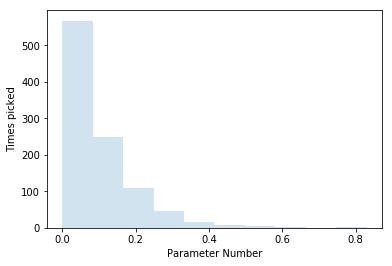

In [23]:
from scipy.stats import expon

plt.hist(expon(scale=0.1).rvs(size=1000), histtype='stepfilled', alpha=0.2)
plt.xlabel('Parameter Number')
plt.ylabel('Times picked')
plt.show()

...or you could use a gamma continuous random variable to provide a more 'normal' distribution.

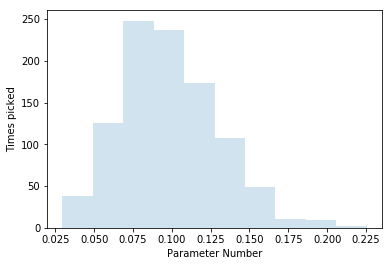

In [24]:
from scipy.stats import gamma

plt.hist(gamma(a=10, scale=0.01).rvs(size=1000), histtype='stepfilled', alpha=0.2)
plt.xlabel('Parameter Number')
plt.ylabel('Times picked')
plt.show()

So instead of a set parameter dictionary lets provide our C with a random number between 0.1 and 8, and the Gamma parameter a gamma distribution around 0.1.

In [25]:
%%time
from sklearn.externals import joblib
from sklearn.model_selection  import RandomizedSearchCV
from scipy.stats import randint as sp_randint

PARAM_DIST = {'clf__C': sp_randint(0.1, 8.), 
              'clf__gamma': gamma(a=10, scale=0.01)}

# Number of parameter settings that are sampled. 
# n_iter trades off runtime vs quality of the solution.
N_ITER = 10

def Rand_Search(X_train, y_train, estimator, cv, n_iter,
                param_dist, scorer, pipe_file_path):
        
  # create gridsearch object
  gs = RandomizedSearchCV(estimator=estimator,
                          param_distributions=param_dist, 
                          n_iter = n_iter,
                          scoring=scorer, 
                          cv=cv,
                          return_train_score=True,
                          n_jobs=-1)

  # fit the gridsearch object
  gs = gs.fit(X_train, y_train)

  # get the results of the gridsearch
  results = pd.DataFrame(gs.cv_results_)

  # select the best estimator
  clf_pipe = gs.best_estimator_

  # save
  joblib.dump(clf_pipe, pipe_file_path)

  display(results[['mean_fit_time','mean_score_time',
                   'params','mean_test_score',
                   'std_test_score']].sort_values(by='mean_test_score',
                                                  ascending =False).head())

Rand_Search(X_train, y_train, pipe_svc, StratKFold, N_ITER, 
            PARAM_GRID, SCORER, 'Rand_SVM.joblib')

,mean_fit_time,mean_score_time,params,mean_test_score,std_test_score
1,0.015264,0.000669,"{'clf__gamma': 0.1, 'clf__C': 4.0}",0.979167,0.027951
7,0.012815,0.000711,"{'clf__gamma': 0.05, 'clf__C': 8.0}",0.979167,0.027951
8,0.008974,0.000640,"{'clf__gamma': 0.005, 'clf__C': 4.0}",0.979167,0.033593
3,0.007257,0.000493,"{'clf__gamma': 0.02, 'clf__C': 4.0}",0.975000,0.042492
4,0.008783,0.000549,"{'clf__gamma': 0.01, 'clf__C': 1.0}",0.975000,0.038188


CPU times: user 126 ms, sys: 7.85 ms, total: 134 ms
Wall time: 913 ms


Imagining we have decided this is the best method to use, we could then use this on our test set as a final performance evaluation.

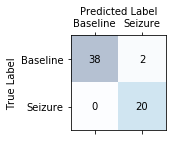

In [26]:
predictions = best_svm_pipe.predict(X_test)

confmat = confusion_matrix(y_true=y_test, y_pred=predictions)

pretty_confusion_matrix(confmat)

## Bayesian Optimization

Optimizing the hyperparameters of a machine learning model could be seen as a minimization problem, as we are looking for the lowest validation loss<sup>1</sup>. Bayesian optimization is a probabilisitic model that can be more efficient than manual, random, or grid search for finding optimal hyperparameters<sup>2</sup>. There are a number of python packages to do bayesian optimization such as...

- Spearmint<sup>3</sup>
    - Gaussian process
- Hyperopt<sup>4</sup>
    - Tree Parzen Estimator (TPE)
- SMAC<sup>5</sup>
    - Random forest regression
    
We are going to use Hyperopt, mainly because there are a number of tutorials on its use<sup>6,7</sup> .

Alike to random search, a search space needs to be specified. Although initally stochastic, as hyperopt gets more feedback from an objective function, it samples parts of the search space that gives it the most meaningful feedback<sup>1</sup>.

We can use STATUS_OK and Trials to store information at each timestep and use them for visualisations. 

**NOTES**
- This implimentation was based on<sup>1</sup>
- For a good conceptual explanation of the method, read [this post]

---

1. https://towardsdatascience.com/an-introductory-example-of-bayesian-optimization-in-python-with-hyperopt-aae40fff4ff0
2. Bergstra, J., Yamins, D., & Cox, D. D. (2013). Making a science of model search: Hyperparameter optimization in hundreds of dimensions for vision architectures.
3. https://github.com/HIPS/Spearmint
4. http://hyperopt.github.io/hyperopt/
5. https://automl.github.io/SMAC3/stable/
6. https://github.com/WillKoehrsen/hyperparameter-optimization/blob/master/Bayesian%20Hyperparameter%20Optimization%20of%20Gradient%20Boosting%20Machine.ipynb
7. https://medium.com/district-data-labs/parameter-tuning-with-hyperopt-faa86acdfdce
[this post]: https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f

In [27]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.preprocessing import StandardScaler

PARAM_DIST = {
  'C': hp.uniform('C', 0, 8),
  'kernel': hp.choice('kernel', ['linear', 'sigmoid', 'poly', 'rbf']),
  'gamma': hp.uniform('gamma', 0, 1),
  'scale': hp.choice('scale', [0, 1])
}

def hyperopt_train_test(params):
  X_ = X_train[:]

  if 'scale' in params:
    if params['scale'] == 1:
      sc = StandardScaler()
      X_ = sc.fit_transform(X_)
    del params['scale']

  clf = SVC(**params)
  return cross_val_score(clf, X_, y_train, cv = 5).mean()

def objective(params):
  acc = hyperopt_train_test(params)
  return {'loss': -acc,             # minus because we need to reduce
          'status': STATUS_OK}

trials = Trials()
best = fmin(objective, PARAM_DIST, 
            algo=tpe.suggest, max_evals=500, 
            trials=trials)

print('best:')
print(best)

100%|██████████| 500/500 [00:29<00:00, 28.87it/s, best loss: -0.9875]
best:
{'C': 5.922596171742327, 'gamma': 0.03691800136313343, 'kernel': 3, 'scale': 1}


We can now plot the accuracy compared to the hyperparameter value...

**NOTES**
- This was based on<sup>1</sup>

---
1. https://medium.com/district-data-labs/parameter-tuning-with-hyperopt-faa86acdfdce

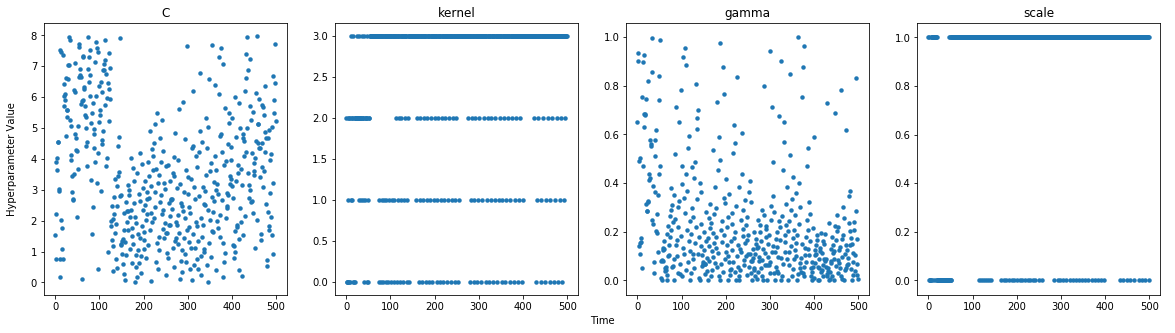

In [28]:
def trials_plot(plot_type):

  parameters = list(PARAM_DIST.keys())

  f, axes = plt.subplots(nrows=1, ncols=len(parameters), figsize=(20,5))

  for i, val in enumerate(parameters):
    ys = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    
    if plot_type=='Accuracy':
      xs = [-t['result']['loss'] for t in trials.trials]
      axes[i].scatter(xs, ys, s=20, linewidth=0.01, 
                    alpha=0.25, c=xs, cmap = plt.cm.jet)
    elif plot_type=='Time':
      xs = [t['tid'] for t in trials.trials]
      axes[i].scatter(xs, ys, s=20, linewidth=0.01)
    else:
      print('plot_type can be Accuracy or Time')
      
    axes[i].set_title(val)

  # add a big axes, hide frame
  f.add_subplot(111, frameon=False)
  # hide tick and tick label of the big axes
  plt.tick_params(labelcolor='none', 
                  top=False, 
                  bottom=False, 
                  left=False, 
                  right=False)
  plt.grid(False)
  plt.xlabel(plot_type)
  plt.ylabel('Hyperparameter Value')

  plt.show()

  
trials_plot(plot_type='Time')  

As we can see above the parameter of C is pretty evenly spred meaning one best value was not really focused on over others, however the gamma shows a preference for lower values over time. If we plot the accuracy and hyperparameter values we can see a similar pattern.

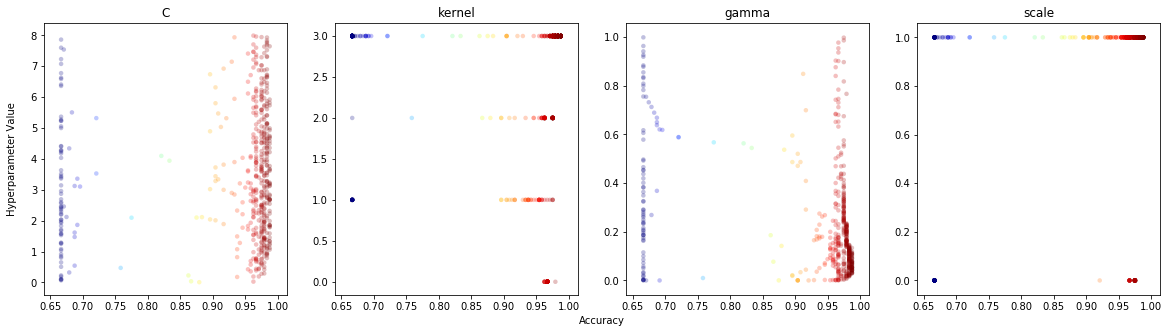

In [29]:
trials_plot(plot_type='Accuracy')

We may want to get out a dataframe similar to what we saw before from the other methods so lets do that before we move on.

In [30]:
df = pd.DataFrame()
for i, t in enumerate(trials.trials):
  df = pd.DataFrame(t['misc']['vals'])
  df['loss'] = t['result']['loss']
  df['tid'] = t['tid']
  df = df.set_index('tid')
  df['time (ms)'] = (t['refresh_time'] - t['book_time']).microseconds/1000
  
  if i ==0:
    results = df
  else:
    results = pd.concat([results, df])
    
    
results.sort_values(by='loss',ascending = True).head()

,C,gamma,kernel,scale,loss,time (ms)
tid,,,,,,
439,3.142441,0.070518,3,1,-0.9875,16.0
262,2.665681,0.091870,3,1,-0.9875,17.0
260,1.852584,0.078945,3,1,-0.9875,18.0
258,1.845575,0.078046,3,1,-0.9875,17.0
252,3.769556,0.053358,3,1,-0.9875,16.0


There is even a version that focuses on making Hyperopt have a more Sklearn API focus


In [31]:
!pip install hpsklearn

  Stored in directory: /root/.cache/pip/wheels/41/ee/c4/3c267cbf78f0905434ee36b915d97a20610ad3af7ff3c75852
Successfully built hpsklearn


WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely
100%|██████████| 1/1 [00:00<00:00, 30.26it/s, best loss: 0.0]


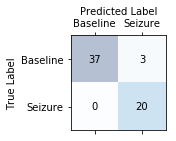

In [32]:
from hpsklearn import HyperoptEstimator, svc
from hpsklearn import standard_scaler, min_max_scaler, normalizer

estim = HyperoptEstimator(
    classifier=svc('mySVC', 
                   kernels=['linear', 'rbf', 'poly', 'sigmoid'],
                   C = hp.uniform('C', 0, 8),
                   gamma = hp.uniform('gamma', 0, 1)),
    preprocessing = [standard_scaler('standard'),
                     min_max_scaler('minmax'),
                     normalizer('Normal')],
    max_evals=10
)

estim.fit(X_train,y_train)

predictions = estim.predict(X_test)

confmat = confusion_matrix(y_true=y_test, y_pred=predictions)

pretty_confusion_matrix(confmat)

## Validation Curves

We can also manually tweek hyperparameters using validation curves. Validation curves are very similar to learning curves, but instead plot the training and test accuracies to see how an estimator performs when varying the models parameters.

Unfortunately mlxtend at time of writing does not have a validation curve, so we'll have to use the easy implimentation provided in Raschka and Mirjalili's book<sup>1</sup>

---
1. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.

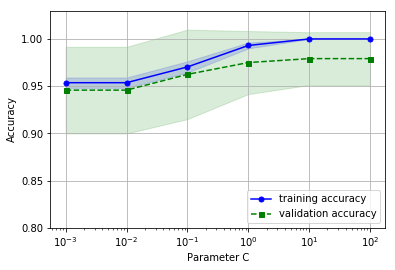

In [33]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

train_scores, test_scores = validation_curve(estimator=pipe_svc,
                                             X=X_train,
                                             y=y_train,
                                             param_name='clf__C',
                                             param_range=param_range,
                                             cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, 
         train_mean,
         color='blue',
         marker='o',
         markersize=5, 
         label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.03])
plt.show()

This can be used to reduce problems with overfitting

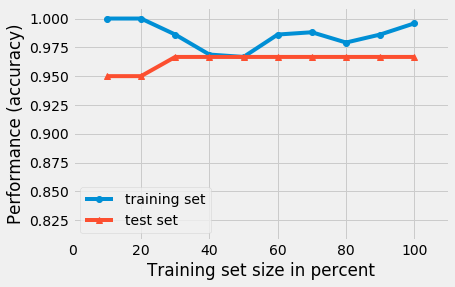

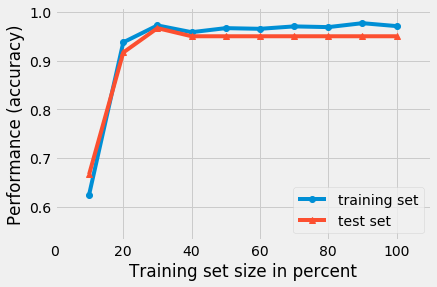

In [34]:
from mlxtend.plotting import plot_learning_curves
from sklearn.base import clone

change_C_SVM = clone(pipe_svc).set_params(**{'clf__C': 0.1})

for svm in [pipe_svc, change_C_SVM]:
  plot_learning_curves(X_train, 
                       y_train, 
                       X_test, 
                       y_test, 
                       svm, 
                       train_marker='o', 
                       test_marker='^', 
                       scoring='accuracy', 
                       print_model =False)
  plt.ylim(top=1.01)
  plt.show()

# Exercises

Below are a few suggested exercises that may help improve your skills.

**TODO**
- Make some exercises...

# License

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.